In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-white')
from statsmodels.tsa.ar_model import AutoReg
from scipy import stats
from scipy.stats import norm
import CRPS.CRPS as pscore
from scipy.stats import pearson3, zipf
import statsmodels.api as sm

# <center> <font color = 'rebeccapurple'>Figure 1</font> </center>

In [2]:
def seasons_lambda_plot(model, ax):
    Data = pd.read_csv('Deterministic_models/Quaboag_'+model+'.csv')    
    Data['normalized diff'] = (Data['diff']/Data['Qgage'])*100
    Spring_obs = Data[Data['month'].isin([3,4,5])]['normalized diff'].values
    Summer_obs = Data[Data['month'].isin([6,7,8])]['normalized diff'].values
    Fall_obs = Data[Data['month'].isin([9,10,11])]['normalized diff'].values
    Winter_obs = Data[Data['month'].isin([12,1,2])]['normalized diff'].values
    
    colors = ["purple", "orange", "brown", "blue"]

    bp = ax.boxplot([Spring_obs, Summer_obs, Fall_obs, Winter_obs], vert=True, patch_artist=True, showfliers=False)

    # Loop over boxes and associated elements
    for patch, whiskers, caps, med, color in zip(
        bp['boxes'],
        zip(bp['whiskers'][0::2], bp['whiskers'][1::2]),  # group whisker pairs
        zip(bp['caps'][0::2], bp['caps'][1::2]),          # group cap pairs
        bp['medians'],
        colors):
        patch.set(color=color, linewidth=2, facecolor='none')   # outline only
        for w in whiskers:
            w.set(color=color, linewidth=2)
        for c in caps:
            c.set(color=color, linewidth=2)
        med.set(color=color, linewidth=2)
        
    ax.axhline(0, ls='--', color='g', zorder=30)

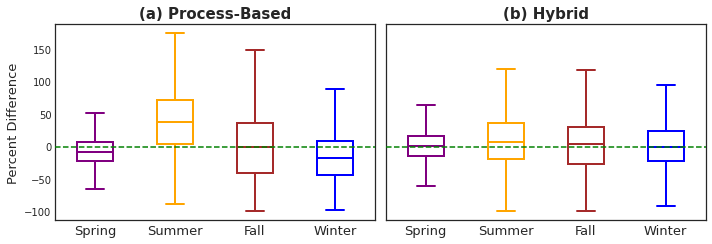

In [5]:
fig= plt.figure(figsize=(10, 3.5))

ax1 = fig.add_subplot(1, 2, 1)
seasons_lambda_plot('HBV', ax1)
ax1.set_xticks([1,2,3,4])
ax1.set_xticklabels(['Spring','Summer','Fall','Winter'], size=13)
ax1.set_ylabel('Percent Difference', size=13)
ax1.set_title('(a) Process-Based', weight='bold', size=15)

ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
seasons_lambda_plot('PP_HBV', ax2)
ax2.yaxis.set_visible(False)
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels(['Spring','Summer','Fall','Winter'], size=13)
ax2.set_title('(b) Hybrid', weight='bold', size=15)

plt.tight_layout()
plt.show()

# <center> <font color = 'rebeccapurple'>Fitting the SWM to historic data</font> </center>

In [ ]:
site = '1176000'
m = 100 # m is the number of random AR parameter sets, Beta, generated for considering AR model uncertainty.
n = 100 # n is the number of stochastic streamflow realizations generated for each Beta set
k = 350

In [ ]:
def calc_NSE(obs,sim):
    """ Returns Nash-Sutcliffe Efficiency
    Input:
    obs - array of observed streamflow record
    sim - array of simulated streamflow record """
    NSE = 1 - (np.sum((obs-sim)**2)/np.sum((obs-np.mean(obs))**2))
    bias_ratio = (np.mean(sim)-np.mean(obs))/np.std(obs)
    variance_ratio = np.std(sim)/np.std(obs)
    correlation = np.corrcoef(sim, obs)[0,1]
    return NSE, bias_ratio, variance_ratio, correlation

def wilson(p,realization):
    '''
    wilson hilforty equation for fitting P3 and finding the recurance interval floods

    Parameters
    ----------
    p : quantile

    Returns
    -------
    Xp : quantile flood

    '''
    zp=norm.ppf(p)
    Z=np.log10(realization)
    Xp=10**(Z.mean() + Z.std() * (2 /Z.skew() *(1 + (Z.skew() * zp)/6 -(Z.skew() **2)/36) **3 - 2/Z.skew()))
    return Xp

In [ ]:
df = pd.read_csv('Deterministic_models/Quaboag_HBV.csv')
df['date'] = pd.to_datetime(df['date'])

snowmelt_df = pd.read_csv('Climate/snowmelt.csv')
snowmelt_df['date'] = pd.to_datetime(snowmelt_df['Date'])
df = df.merge(snowmelt_df[['date',site]], how='left')
df = df.rename(columns={site:'snowmelt'})

In [ ]:
p=3 #order of AR (autocorrelation with lag 3)
d=0 #order of I (no trend)
q=0 #order of MA (no moving average component)

mod = AutoReg(df['lambda'], lags=p) #set up AR3 model using lambdas as input
res = mod.fit() #fit model

df['Ar_res']=res.resid
first3_fitted = np.zeros(3)
first3_fitted[0] = res.params.iloc[0]
first3_fitted[1] = res.params.iloc[0] + res.params.iloc[1]*df.loc[0, 'lambda']
first3_fitted[2] = res.params.iloc[0] + res.params.iloc[1]*df.loc[1, 'lambda'] + res.params.iloc[2]*df.loc[0, 'lambda']
first3_res = df['lambda'][:3] - first3_fitted
df.loc[:2, 'Ar_res'] = first3_res

# for reproducible Betas, use scipy.stats multivariate_normal function instead, setting random seed
Beta = stats.multivariate_normal(np.array(res.params),np.array(res.cov_params()), seed=3)
Beta = Beta.rvs(m)

# KNN bootstrap (k should be calibrated to the basin)
Epsilon = pd.DataFrame(df['Ar_res']) # make dataframe of residuals
Epsilon['Qmodel'] = np.array(df['Qmodel']) #add in column to dataframe of modeled flows
Epsilon = np.array(Epsilon) # turn dataframe into numpy array

E = [] #initialize empty list to store errors
for t in range(0,len(df)): # loop through all time periods
    E.append(Epsilon - [0,Epsilon[t,1]])  # first column residual, second column diff between flow and all other flows

Er = np.zeros((len(df),k)) #initialize empty 2d array with dimensions time periods x k (# nearest neighbors)
for t in range(0,len(df)): #loop through all time periods
    E[t][:,1] = np.abs(E[t][:,1]) #get absolute values of errors
    x = E[t][np.argsort(E[t][:, 1])] #sort errors by magnitude
    Er[t,:] = x[0:k,0] # get the AR residuals from the k closest flows

R = np.zeros((len(df),n*m)) #initialize empty 2d array with dimensions time periods x # realizations
for i in range(0,n*m): #loop through all realizations
    I = np.random.randint(low=0, high=k, size=len(df)) #randomly identify indices
    R[:,i] = Er[tuple(np.arange(0,len(df),1)),I] #sample from Er at random indices I
    
E = R #set E to equal R

# l is a matrix of [len(data),m*n] representing stochastic log-ratio errors         
L = np.ones((len(df),m*n))*-99 #initialize empty array to populate below

# for the first four time periods, we set values to be the deterministic model lambdas across all realizations
# this is because we do not have enough time periods in the past to populate the AR3 model stochastically
for i in range(0,m*n):
    L[0:3,i] = df['lambda'].iloc[0:3]

for t in range(3,len(df)):
    if df['Qmodel'][t] <= 5:
        rule_point = -4.5
    if (df['Qmodel'][t] > 5) & (df['Qmodel'][t] <= 50):
        rule_point = -2.5
    if (df['Qmodel'][t] > 50) & (df['Qmodel'][t] <= 150):
        rule_point = -2
    if (df['Qmodel'][t] > 150) & (df['Qmodel'][t] <= 250):
        rule_point = -1.75
    if (df['Qmodel'][t] > 250) & (df['Qmodel'][t] <= 500):
        rule_point = -1.5
    if (df['Qmodel'][t] > 500) & (df['Qmodel'][t] <= 1000):
        rule_point = -1
    if (df['Qmodel'][t] > 1000) & (df['Qmodel'][t] <= 1500):
        rule_point = -0.75
    if df['Qmodel'][t] > 1500:
        rule_point = -0.5
    
    for i in range(0,m*n):
        B = Beta[i//m,:]
        L[t, i] = B[0] + \
                  B[1] * L[t-1, i] + \
                  B[2] * L[t-2, i] + \
                  B[3] * L[t-3, i] + \
                  E[t, i]
        
        if L[t, i] < rule_point:
            reflection_diff = L[t, i] - rule_point
            L[t, i] = rule_point - reflection_diff
            E[t, i] = E[t, i] - (2*reflection_diff)
        
# Q is a matrix of stochastically simulated streamflows of size [m*n, len(data)]
# Just like lambda = log(Qmodel/Qgage), we now set Q = Qmodel/e^L where
# L is stochastic lambdas and Q is stochastic streamflow
Q = np.array(df['Qmodel']) / np.exp(L.T)

In [ ]:
SWM_Q = pd.DataFrame(Q.T)
log_SWM_Q = np.log(SWM_Q)
SWM_Q.insert(0, 'date', df['date'])
log_SWM_Q.insert(0, 'date', df['date'])
current_year_group = 0
year_groups = []
for row in range(len(SWM_Q)):
    current_row = SWM_Q.iloc[row, :]
    if current_row['date'].month != 9 or current_row['date'].day != 30:
        year_groups.append(current_year_group)
    else:
        year_groups.append(current_year_group)
        current_year_group += 1
SWM_Q.insert(1, 'year groups', year_groups)
log_SWM_Q.insert(1, 'year groups', year_groups)

OutlierDates_1955 = pd.date_range(start='1955-08-18', end='1955-08-31', freq='D').tolist()
OutlierDates = OutlierDates_1955
# give larger buffer for SWM
OutlierDates_1955_SWM_PreFlood = pd.date_range(end='1955-08-17', periods=7, freq='D').tolist()
OutlierDates_1955_SWM_PostFlood = pd.date_range(start='1955-09-01', periods=7, freq='D').tolist()
OutlierDates_SWM = OutlierDates + OutlierDates_1955_SWM_PreFlood + OutlierDates_1955_SWM_PostFlood
NoOutliers_SWM_Q = SWM_Q.set_index(SWM_Q['date']).drop(index=OutlierDates_SWM, errors='ignore').reset_index(drop=True)

Qobs = df['Qgage'].values
logQobs = np.log(Qobs)

CRPS_scores = np.zeros(len(df))
logCRPS_scores = np.zeros(len(df))

for i in range(len(df)):
    CRPS_score = pscore(SWM_Q.iloc[i, 2:].astype(float), Qobs[i]).compute()[0]
    CRPS_scores[i] = CRPS_score

    logCRPS_score = pscore(log_SWM_Q.iloc[i, 2:].astype(float), logQobs[i]).compute()[0]
    logCRPS_scores[i] = logCRPS_score
    
AnnualMax_df = NoOutliers_SWM_Q.groupby('year groups').max().iloc[:, 1:].reset_index(drop=True)

AnnualMax_months_df = NoOutliers_SWM_Q.groupby('year groups').idxmax().map(lambda x: NoOutliers_SWM_Q['date'][x])\
                      .iloc[:, 1:].reset_index(drop=True)
AnnualMax_months_df = AnnualMax_months_df.apply(lambda col: col.dt.month)

Tyr_flood_yrs = np.concatenate((np.arange(10, 101), np.array([125, 150, 175, 200, 250, 300, 350, 400, 450, 500])))
SWM_Tyr_floods_df = pd.DataFrame(columns=AnnualMax_df.columns)
for flood_T in Tyr_flood_yrs:
    Tyr_flood = np.zeros(len(AnnualMax_df.columns))
    for i in range(len(AnnualMax_df.columns)):
        Tyr_flood[i] = wilson(1-(1/flood_T), AnnualMax_df[i])
    SWM_Tyr_floods_df.loc[flood_T] = Tyr_flood
    
rolling7 = SWM_Q.set_index(SWM_Q['date']).iloc[:, 2:].rolling(7).mean().reset_index(drop=True)
rolling7.insert(0, 'year groups', SWM_Q['year groups'])
low7day_months_df = rolling7.groupby(rolling7['year groups']).idxmin().map(lambda x: SWM_Q['date'][x])\
                    .reset_index(drop=True)
low7day_months_df = low7day_months_df.apply(lambda col: col.dt.month)

In [ ]:
AnnualMax_obs = NoOutliers_df.groupby('water_year').max()['Qgage'].values
AnnualMax_months_obs = NoOutliers_df['date'].dt.month[NoOutliers_df.groupby('water_year').idxmax()['Qgage'].values].values
TyrFlood_obs = np.ones(len(Tyr_flood_yrs))*-99
for i in range(len(Tyr_flood_yrs)):
    flood_T = Tyr_flood_yrs[i]
    TyrFlood_obs[i] = wilson(1-(1/flood_T), pd.Series(AnnualMax_obs))
rolling7 = df.set_index(df['date'])[['Qgage','Qmodel']].rolling(7).mean().reset_index(drop=True)
rolling7.insert(0, 'water_year', df['water_year'])
low7day_months_obs = df['date'].dt.month[rolling7.groupby('water_year').idxmin()['Qgage'].values].values

# <center> <font color = 'rebeccapurple'>Figure 5</font> </center>

In [6]:
PRMS_data = pd.read_csv('Deterministic_models/Quaboag_PRMS.csv')
PP_PRMS_data = pd.read_csv('Deterministic_models/Quaboag_PP_PRMS.csv')

Hymod_data = pd.read_csv('Deterministic_models/Quaboag_Hymod.csv')
PP_Hymod_data = pd.read_csv('Deterministic_models/Quaboag_PP_Hymod.csv')

HBV_data = pd.read_csv('Deterministic_models/Quaboag_HBV.csv')
PP_HBV_data = pd.read_csv('Deterministic_models/Quaboag_PP_HBV.csv')

LSTM_data = pd.read_csv('Deterministic_models/Quaboag_LSTM.csv')

In [8]:
PRMS_NSE = calc_NSE(PRMS_data['Qgage'], PRMS_data['Qmodel'])[0]
PP_PRMS_NSE = calc_NSE(PP_PRMS_data['Qgage'], PP_PRMS_data['Qmodel'])[0]

Hymod_NSE = calc_NSE(Hymod_data['Qgage'], Hymod_data['Qmodel'])[0]
PP_Hymod_NSE = calc_NSE(PP_Hymod_data['Qgage'], PP_Hymod_data['Qmodel'])[0]

HBV_NSE = calc_NSE(HBV_data['Qgage'], HBV_data['Qmodel'])[0]
PP_HBV_NSE = calc_NSE(PP_HBV_data['Qgage'], PP_HBV_data['Qmodel'])[0]

LSTM_NSE = calc_NSE(LSTM_data['Qgage'], LSTM_data['Qmodel'])[0]

In [10]:
PRMS_CRPS = np.mean(np.load('CRPS/PRMS_CRPS.npy'))
Hymod_CRPS = np.mean(np.load('CRPS/Hymod_CRPS.npy'))
HBV_CRPS = np.mean(np.load('CRPS/HBV_CRPS.npy'))
LSTM_CRPS = np.mean(np.load('CRPS/LSTM_CRPS.npy'))
PP_PRMS_CRPS = np.mean(np.load('CRPS/PP_PRMS_CRPS.npy'))
PP_Hymod_CRPS = np.mean(np.load('CRPS/PP_Hymod_CRPS.npy'))
PP_HBV_CRPS = np.mean(np.load('CRPS/PP_HBV_CRPS.npy'))

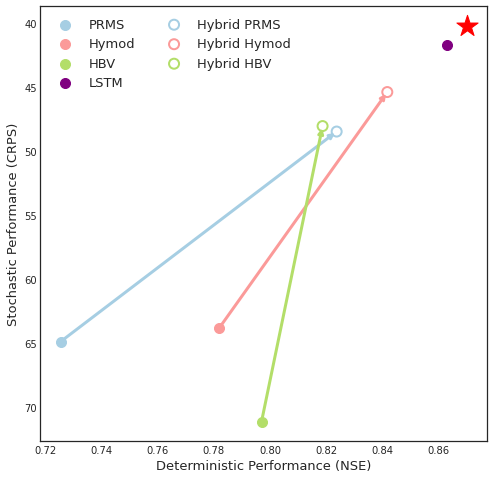

In [11]:
plt.figure(figsize=(8,8))

plt.scatter(PRMS_NSE, PRMS_CRPS, color='#a6cee3', label='PRMS', s=100)
plt.scatter(PP_PRMS_NSE, PP_PRMS_CRPS, color='#a6cee3', label='Hybrid PRMS', facecolors='None', s=100, linewidths=2)
plt.annotate('', xy=(PP_PRMS_NSE, PP_PRMS_CRPS), xytext=(PRMS_NSE, PRMS_CRPS), arrowprops=dict(arrowstyle='->', 
                                                                                               color='#a6cee3', lw=3))

plt.scatter(Hymod_NSE, Hymod_CRPS, color='#fb9a99', label='Hymod', s=100)
plt.scatter(PP_Hymod_NSE, PP_Hymod_CRPS, color='#fb9a99', label='Hybrid Hymod', facecolors='None', s=100, linewidths=2)
plt.annotate('', xy=(PP_Hymod_NSE, PP_Hymod_CRPS), xytext=(Hymod_NSE, Hymod_CRPS), arrowprops=dict(arrowstyle='->', 
                                                                                                   color='#fb9a99', lw=3))

plt.scatter(HBV_NSE, HBV_CRPS, color='#b3de69', label='HBV', s=100)
plt.scatter(PP_HBV_NSE, PP_HBV_CRPS, color='#b3de69', label='Hybrid HBV', facecolors='None', s=100, linewidths=2)
plt.annotate('', xy=(PP_HBV_NSE, PP_HBV_CRPS), xytext=(HBV_NSE, HBV_CRPS), arrowprops=dict(arrowstyle='->', 
                                                                                           color='#b3de69', lw=3))

plt.scatter(LSTM_NSE, LSTM_CRPS, color='purple', label='LSTM', s=100)

x_star = plt.xlim()[1]
y_star = plt.ylim()[0]
plt.scatter(x_star, y_star, color='red', marker='*', s=500)

x_lim = plt.xlim()
y_lim = plt.ylim()

plt.gca().invert_yaxis()

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[0], handles[2], handles[4], handles[6], handles[1], handles[3], handles[5]], 
           [labels[0], labels[2], labels[4], labels[6], labels[1], labels[3], labels[5]],
           fontsize=13, ncol=2, loc='upper left')
plt.ylabel('Stochastic Performance (CRPS)', size=13)
plt.xlabel('Deterministic Performance (NSE)', size=13)
plt.show()

In [12]:
log_PRMS_data = pd.read_csv('Deterministic_models/Quaboag_PRMS.csv')
log_PRMS_data['Qgage'] = np.log(log_PRMS_data['Qgage'])
log_PRMS_data['Qmodel'] = np.log(log_PRMS_data['Qmodel'])

log_PP_PRMS_data = pd.read_csv('Deterministic_models/Quaboag_PP_PRMS.csv')
log_PP_PRMS_data['Qgage'] = np.log(log_PP_PRMS_data['Qgage'])
log_PP_PRMS_data['Qmodel'] = np.log(log_PP_PRMS_data['Qmodel'])

log_Hymod_data = pd.read_csv('Deterministic_models/Quaboag_Hymod.csv')
log_Hymod_data['Qgage'] = np.log(log_Hymod_data['Qgage'])
log_Hymod_data['Qmodel'] = np.log(log_Hymod_data['Qmodel'])

log_PP_Hymod_data = pd.read_csv('Deterministic_models/Quaboag_PP_Hymod.csv')
log_PP_Hymod_data['Qgage'] = np.log(log_PP_Hymod_data['Qgage'])
log_PP_Hymod_data['Qmodel'] = np.log(log_PP_Hymod_data['Qmodel'])

log_HBV_data = pd.read_csv('Deterministic_models/Quaboag_HBV.csv')
log_HBV_data['Qgage'] = np.log(log_HBV_data['Qgage'])
log_HBV_data['Qmodel'] = np.log(log_HBV_data['Qmodel'])

log_PP_HBV_data = pd.read_csv('Deterministic_models/Quaboag_PP_HBV.csv')
log_PP_HBV_data['Qgage'] = np.log(log_PP_HBV_data['Qgage'])
log_PP_HBV_data['Qmodel'] = np.log(log_PP_HBV_data['Qmodel'])

log_LSTM_data = pd.read_csv('Deterministic_models/Quaboag_LSTM.csv')
log_LSTM_data['Qgage'] = np.log(log_LSTM_data['Qgage'])
log_LSTM_data['Qmodel'] = np.log(log_LSTM_data['Qmodel'])

In [15]:
log_PRMS_NSE = calc_NSE(log_PRMS_data['Qgage'], log_PRMS_data['Qmodel'])[0]
log_PP_PRMS_NSE = calc_NSE(log_PP_PRMS_data['Qgage'], log_PP_PRMS_data['Qmodel'])[0]

log_Hymod_NSE = calc_NSE(log_Hymod_data['Qgage'], log_Hymod_data['Qmodel'])[0]
log_PP_Hymod_NSE = calc_NSE(log_PP_Hymod_data['Qgage'], log_PP_Hymod_data['Qmodel'])[0]

log_HBV_NSE = calc_NSE(log_HBV_data['Qgage'], log_HBV_data['Qmodel'])[0]
log_PP_HBV_NSE = calc_NSE(log_PP_HBV_data['Qgage'], log_PP_HBV_data['Qmodel'])[0]

log_LSTM_NSE = calc_NSE(log_LSTM_data['Qgage'], log_LSTM_data['Qmodel'])[0]

In [13]:
log_PRMS_CRPS = np.mean(np.load('logCRPS/PRMS_logCRPS.npy'))
log_Hymod_CRPS = np.mean(np.load('logCRPS/Hymod_logCRPS.npy'))
log_HBV_CRPS = np.mean(np.load('logCRPS/HBV_logCRPS.npy'))
log_LSTM_CRPS = np.mean(np.load('logCRPS/LSTM_logCRPS.npy'))
log_PP_PRMS_CRPS = np.mean(np.load('logCRPS/PP_PRMS_logCRPS.npy'))
log_PP_Hymod_CRPS = np.mean(np.load('logCRPS/PP_Hymod_logCRPS.npy'))
log_PP_HBV_CRPS = np.mean(np.load('logCRPS/PP_HBV_logCRPS.npy'))

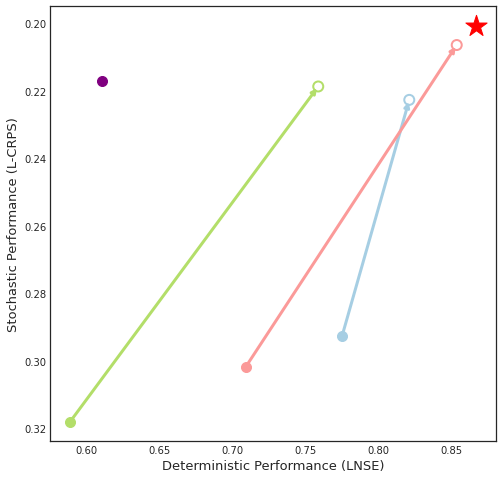

In [16]:
plt.figure(figsize=(8,8))

plt.scatter(log_PRMS_NSE, log_PRMS_CRPS, color='#a6cee3', label='PRMS', s=100)
plt.scatter(log_PP_PRMS_NSE, log_PP_PRMS_CRPS, color='#a6cee3', label='Hybrid PRMS', facecolors='None', s=100, linewidths=2)
plt.annotate('', xy=(log_PP_PRMS_NSE, log_PP_PRMS_CRPS), xytext=(log_PRMS_NSE, log_PRMS_CRPS), arrowprops=dict(arrowstyle='->', 
                                                                                               color='#a6cee3', lw=3))

plt.scatter(log_Hymod_NSE, log_Hymod_CRPS, color='#fb9a99', label='Hymod', s=100)
plt.scatter(log_PP_Hymod_NSE, log_PP_Hymod_CRPS, color='#fb9a99', label='Hybrid Hymod', facecolors='None', s=100, linewidths=2)
plt.annotate('', xy=(log_PP_Hymod_NSE, log_PP_Hymod_CRPS), xytext=(log_Hymod_NSE, log_Hymod_CRPS), arrowprops=dict(arrowstyle='->', 
                                                                                                   color='#fb9a99', lw=3))

plt.scatter(log_HBV_NSE, log_HBV_CRPS, color='#b3de69', label='HBV', s=100)
plt.scatter(log_PP_HBV_NSE, log_PP_HBV_CRPS, color='#b3de69', label='Hybrid HBV', facecolors='None', s=100, linewidths=2)
plt.annotate('', xy=(log_PP_HBV_NSE, log_PP_HBV_CRPS), xytext=(log_HBV_NSE, log_HBV_CRPS), arrowprops=dict(arrowstyle='->', 
                                                                                           color='#b3de69', lw=3))

plt.scatter(log_LSTM_NSE, log_LSTM_CRPS, color='purple', label='LSTM', s=100)

x_star = plt.xlim()[1]
y_star = plt.ylim()[0]
plt.scatter(x_star, y_star, color='red', marker='*', s=500)

x_lim = plt.xlim()
y_lim = plt.ylim()

plt.gca().invert_yaxis()

handles, labels = plt.gca().get_legend_handles_labels()
plt.ylabel('Stochastic Performance (L-CRPS)', size=13)
plt.xlabel('Deterministic Performance (LNSE)', size=13)
plt.show()

# <center> <font color = 'rebeccapurple'>Figure 6</font> </center>

In [2]:
def skew_var(skew, n):
    a = (-17.75/(n**2))+(50.06/(n**3))
    b = (3.92/(n**0.3))-(31.1/(n**0.6))+(34.86/(n**0.9))
    c = (-7.31/(n**0.59))+(45.9/(n**1.18))-(86.5/(n**1.77))
    var = ((6/n)+a)*(1+(((9/6)+b)*(skew**2))+(((15/(6*8))+c)*(skew**4)))
    return var

def wilhil_approx(mean, std, skew, p):
    zp=norm.ppf(p)
    xp = mean + std * (((2 /skew) * ((1 + ((skew * zp)/6) - ((skew **2)/36)) **3)) - (2/skew))
    return xp

def zeta_ppf(p, alpha, n):
    zp = norm.ppf(p)
    za = norm.ppf(alpha)
    zeta = (zp + (za * np.sqrt((1/n) + ((zp**2)/(2*(n-1))) - ((za**2)/(2*n*(n-1))))))/(1-((za**2)/(2*(n-1))))
    return zeta

def confidenceinterval(n, alpha, p, mean, std, skew):
    zp = norm.ppf(p)
    derivative = ((1/6)*((zp**2)-1)*(1-(3*((skew/6)**2)))) + (((zp**3)-6*zp)*(skew/54)) + ((2/3)*zp*((skew/6)**3))
    
    Kp = ((2 /skew) * ((1 + ((skew * zp)/6) - ((skew **2)/36)) **3)) - (2/skew)
    var_skew = skew_var(skew, n)
    eta_numerator = 1 + skew*Kp + (1/2)*(1+(3/4)*(skew**2))*(Kp**2) + n*var_skew*(derivative**2)
    eta_denominator = 1 + (1/2)*(zp**2)
    eta = np.sqrt(eta_numerator/eta_denominator)
    
    #yp = wilhil_approx(mean, std, skew, p)
    yp = pearson3.ppf(q=p, skew=skew, loc=mean, scale=std)
    zeta_1_a = zeta_ppf(p, 1-alpha, n)
    zeta_a = zeta_ppf(p, alpha, n)
    lower_bound = yp + eta*(zeta_a - zp)*std
    upper_bound = yp + eta*(zeta_1_a - zp)*std
    
    return lower_bound, upper_bound

In [3]:
def Tyr_flood_stats(model, a):
    hist_floods = pd.read_csv('Floods/'+model+'_Tyr_floods.csv')
    obs_floods = np.load('Floods/obs_Tyr_floods.npy')

    flood_Ts = hist_floods.iloc[:, 0].values
    hist_floods = pd.read_csv('Floods/'+model+'_Tyr_floods.csv').iloc[:, 1:]
    
    obs_AnnualMax = np.load('Floods/obs_AnnualMax.npy')
    
    Z_obs = np.log10(pd.Series(obs_AnnualMax))
    CIs = np.zeros((len(flood_Ts), 2))
    for i in range(len(flood_Ts)):
        T = flood_Ts[i]
        lower_bound, upper_bound = confidenceinterval(n=len(obs_AnnualMax), alpha=a, p=1-(1/T), mean=Z_obs.mean(), 
                                                      std=Z_obs.std(), skew=Z_obs.skew())
        CIs[i,0] = 10**lower_bound
        CIs[i,1] = 10**upper_bound
    
    return flood_Ts, hist_floods, obs_floods, CIs

In [7]:
PRMS_Ts, PRMS_SWM, PRMS_obs, PRMS_CIs = Tyr_flood_stats('PRMS', 0.025)
PP_PRMS_Ts, PP_PRMS_SWM, PP_PRMS_obs, PP_PRMS_CIs = Tyr_flood_stats('PP_PRMS', 0.025)

Hymod_Ts, Hymod_SWM, Hymod_obs, Hymod_CIs = Tyr_flood_stats('Hymod', 0.025)
PP_Hymod_Ts, PP_Hymod_SWM, PP_Hymod_obs, PP_Hymod_CIs = Tyr_flood_stats('PP_Hymod', 0.025)

HBV_Ts, HBV_SWM, HBV_obs, HBV_CIs = Tyr_flood_stats('HBV', 0.025)
PP_HBV_Ts, PP_HBV_SWM, PP_HBV_obs, PP_HBV_CIs = Tyr_flood_stats('PP_HBV', 0.025)

LSTM_Ts, LSTM_SWM, LSTM_obs, LSTM_CIs = Tyr_flood_stats('LSTM', 0.025)

In [9]:
def Tyr_flood_performance(SWM, obs, CIs, alf):
    percent_error = np.ones(len(SWM))*-99
    CI_metric = np.ones(len(SWM))*-99
    for i in range(len(SWM)):
        counts, bin_edges = np.histogram(SWM.iloc[i], bins=100)
        max_bin_index = np.argmax(counts)
        bin_start = bin_edges[max_bin_index]
        bin_end = bin_edges[max_bin_index + 1]
        mode_SWM = (bin_start+bin_end)/2
        percent_error[i] = 100*np.abs((mode_SWM-obs[i])/obs[i])
        
        SWM_in_band = len(SWM.iloc[i][(SWM.iloc[i]>=CIs[i,0]) & (SWM.iloc[i]<=CIs[i,1])])/len(SWM.iloc[i])
        CI_metric[i] = 100*np.abs(1-(SWM_in_band/(1-2*alf)))
    
    return np.median(percent_error), np.median(CI_metric)

In [10]:
PRMS_det, PRMS_stoch = Tyr_flood_performance(PRMS_SWM, PRMS_obs, PRMS_CIs, 0.025)
PP_PRMS_det, PP_PRMS_stoch = Tyr_flood_performance(PP_PRMS_SWM, PP_PRMS_obs, PP_PRMS_CIs, 0.025)

Hymod_det, Hymod_stoch = Tyr_flood_performance(Hymod_SWM, Hymod_obs, Hymod_CIs, 0.025)
PP_Hymod_det, PP_Hymod_stoch = Tyr_flood_performance(PP_Hymod_SWM, PP_Hymod_obs, PP_Hymod_CIs, 0.025)

HBV_det, HBV_stoch = Tyr_flood_performance(HBV_SWM, HBV_obs, HBV_CIs, 0.025)
PP_HBV_det, PP_HBV_stoch = Tyr_flood_performance(PP_HBV_SWM, PP_HBV_obs, PP_HBV_CIs, 0.025)

LSTM_det, LSTM_stoch = Tyr_flood_performance(LSTM_SWM, LSTM_obs, LSTM_CIs, 0.025)

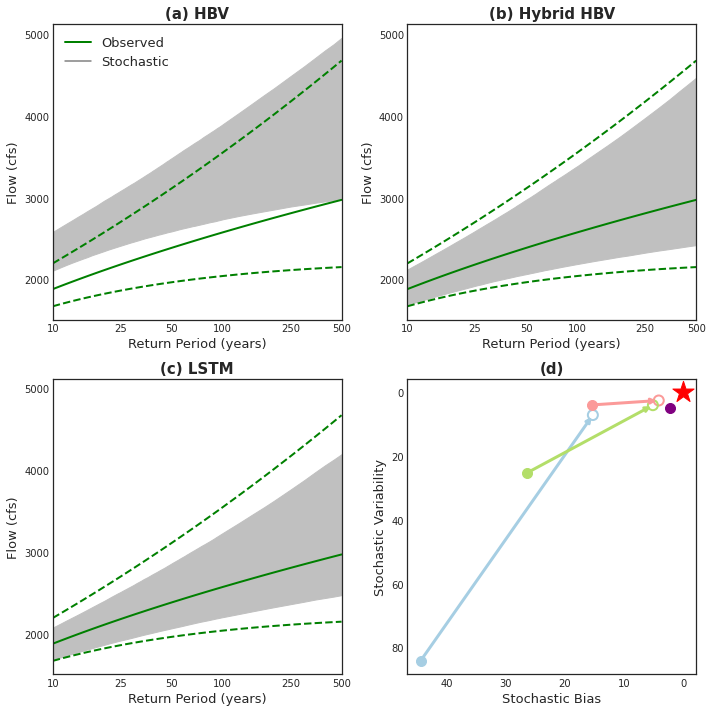

In [11]:
fig = plt.figure(figsize=(10,10))
    
ax1 = fig.add_subplot(2, 2, 1)
ax1.fill_between(HBV_Ts, HBV_SWM.quantile(0.025, axis=1), HBV_SWM.quantile(0.975, axis=1), color='silver')
ax1.plot(HBV_Ts, HBV_obs, color='g', label='Observed', lw=2)
#ax1.plot(HBV_Ts, HBV_mod, color='k', label='Deterministic', lw=2)
ax1.plot([],[],color='gray',label='Stochastic')
ax1.plot(HBV_Ts, HBV_CIs[:, 0], color='g', ls='--', lw=2)
ax1.plot(HBV_Ts, HBV_CIs[:, 1], color='g', ls='--', lw=2)
ax1.legend(fontsize=13)
ax1.set_ylabel('Flow (cfs)', size=13)
ax1.set_xscale('log')
ax1.set_xlim(10,500)
ax1.set_xlabel('Return Period (years)', size=13)
ax1.set_xticks([10, 25, 50, 100, 250, 500], ['10', '25', '50', '100', '250', '500'])
ax1.set_yticks([2000,3000,4000,5000])
ax1.set_title('(a) HBV', weight='bold', size=15)
    
ax2 = fig.add_subplot(2, 2, 2, sharex=ax1, sharey=ax1)
ax2.fill_between(PP_HBV_Ts, PP_HBV_SWM.quantile(0.025, axis=1), PP_HBV_SWM.quantile(0.975, axis=1), color='silver')
ax2.plot(PP_HBV_Ts, PP_HBV_obs, color='g', label='Observed', lw=2)
#ax2.plot(PP_HBV_Ts, PP_HBV_mod, color='k', label='Deterministic', lw=2)
ax2.plot(PP_HBV_Ts, PP_HBV_CIs[:, 0], color='g', ls='--', lw=2)
ax2.plot(PP_HBV_Ts, PP_HBV_CIs[:, 1], color='g', ls='--', lw=2)
#ax2.legend(fontsize=13, loc='upper right')
ax2.set_xscale('log')
ax2.set_xlabel('Return Period (years)', size=13)
ax2.set_xticks([10, 25, 50, 100, 250, 500], ['10', '25', '50', '100', '250', '500'])
ax2.set_ylabel('Flow (cfs)', size=13)
ax2.set_title('(b) Hybrid HBV', weight='bold', size=15)

ax3 = fig.add_subplot(2, 2, 3, sharex=ax1, sharey=ax1)
ax3.fill_between(LSTM_Ts, LSTM_SWM.quantile(0.025, axis=1), LSTM_SWM.quantile(0.975, axis=1), color='silver')
ax3.plot(LSTM_Ts, LSTM_obs, color='g', label='Observed', lw=2)
#ax3.plot(LSTM_Ts, LSTM_mod, color='k', label='Deterministic', lw=2)
ax3.plot(LSTM_Ts, LSTM_CIs[:, 0], color='g', ls='--', lw=2)
ax3.plot(LSTM_Ts, LSTM_CIs[:, 1], color='g', ls='--', lw=2)
#ax3.legend(fontsize=13, loc='upper right')
ax3.set_xscale('log')
ax3.set_xlabel('Return Period (years)', size=13)
ax3.set_xticks([10, 25, 50, 100, 250, 500], ['10', '25', '50', '100', '250', '500'])
ax3.set_ylabel('Flow (cfs)', size=13)
ax3.set_title('(c) LSTM', weight='bold', size=15)

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(PRMS_det, PRMS_stoch, color='#a6cee3', label='PRMS', s=100)
ax4.scatter(PP_PRMS_det, PP_PRMS_stoch, color='#a6cee3', label='Hybrid PRMS', facecolors='None', s=100, linewidths=2)
ax4.annotate('', xy=(PP_PRMS_det, PP_PRMS_stoch), xytext=(PRMS_det, PRMS_stoch), arrowprops=dict(arrowstyle='->', 
                                                                                               color='#a6cee3', lw=3))
ax4.scatter(Hymod_det, Hymod_stoch, color='#fb9a99', label='Hymod', s=100)
ax4.scatter(PP_Hymod_det, PP_Hymod_stoch, color='#fb9a99', label='Hybrid Hymod', facecolors='None', s=100, linewidths=2)
ax4.annotate('', xy=(PP_Hymod_det, PP_Hymod_stoch), xytext=(Hymod_det, Hymod_stoch), arrowprops=dict(arrowstyle='->', 
                                                                                                   color='#fb9a99', lw=3))
ax4.scatter(HBV_det, HBV_stoch, color='#b3de69', label='HBV', s=100)
ax4.scatter(PP_HBV_det, PP_HBV_stoch, color='#b3de69', label='Hybrid HBV', facecolors='None', s=100, linewidths=2)
ax4.annotate('', xy=(PP_HBV_det, PP_HBV_stoch), xytext=(HBV_det, HBV_stoch), arrowprops=dict(arrowstyle='->', 
                                                                                           color='#b3de69', lw=3))
ax4.scatter(LSTM_det, LSTM_stoch, color='purple', label='LSTM', s=100)
x_star = 0
y_star = 0
ax4.scatter(x_star, y_star, color='red', marker='*', s=500)
x_lim = ax4.get_xlim()
y_lim = ax4.get_ylim()
ax4.set_xlabel('Stochastic Bias', size=13)
ax4.set_ylabel('Stochastic Variability', size=13)
ax4.invert_xaxis()
ax4.invert_yaxis()
handles_bottom, labels_bottom = ax4.get_legend_handles_labels()
#ax4.legend([handles_bottom[0], handles_bottom[2], handles_bottom[4], handles_bottom[6], handles_bottom[1], handles_bottom[3], 
#            handles_bottom[5]], [labels_bottom[0], labels_bottom[2], labels_bottom[4], labels_bottom[6], labels_bottom[1], 
#                                 labels_bottom[3], labels_bottom[5]], ncol=2, loc='lower right', fontsize=13)
ax4.set_title('(d)', weight='bold', size=15)

plt.tight_layout()
plt.show()

# <center> <font color = 'rebeccapurple'>Figure 7</font> </center>

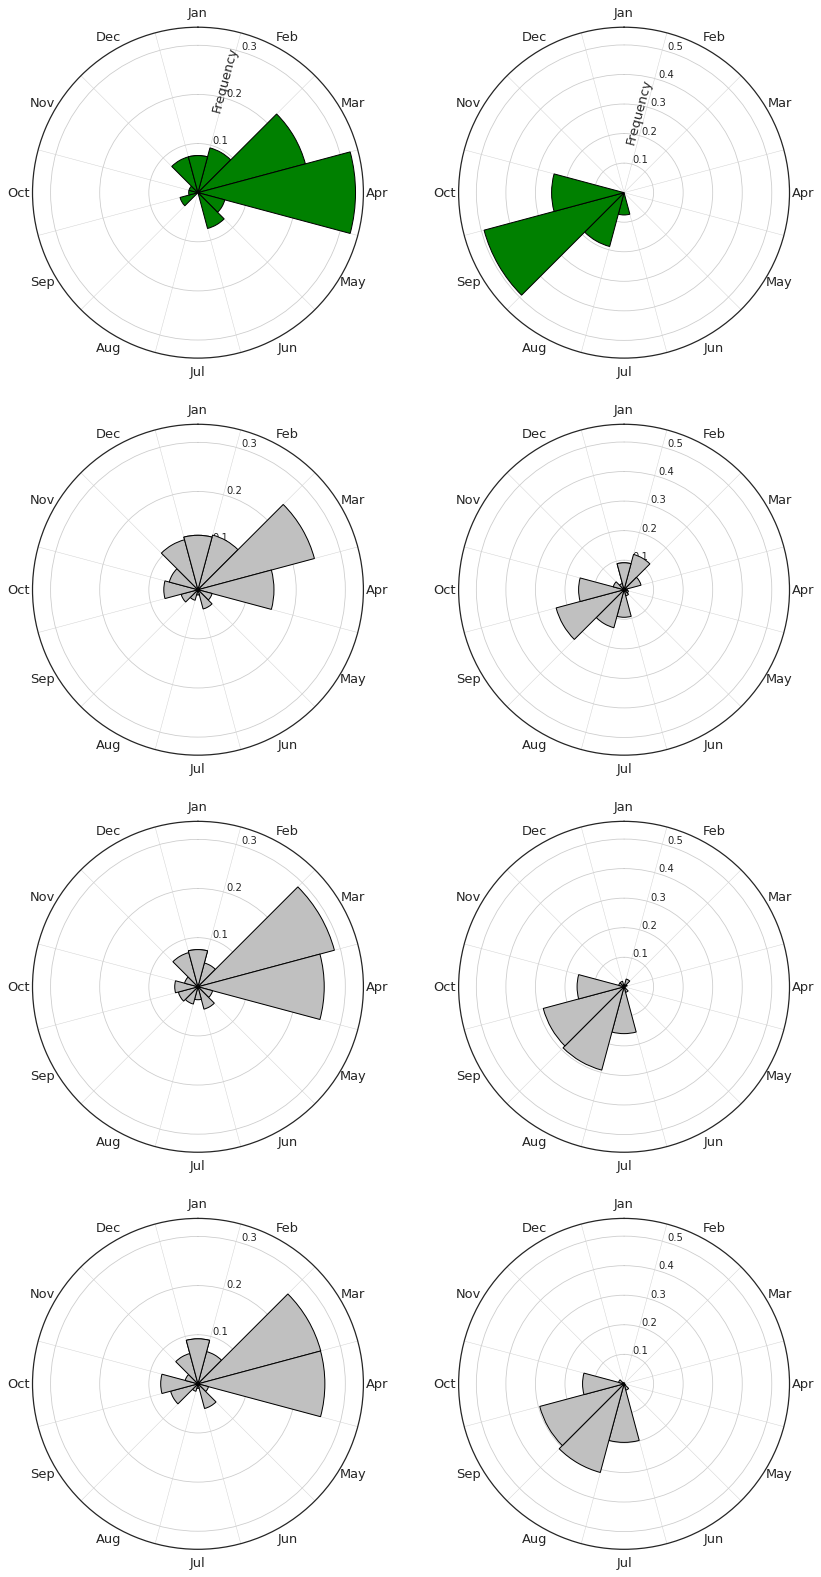

In [12]:
obs_AnnualMax_months = np.load('Months/obs_AnnualMax_months.npy')
SWM_AnnualMax_months = pd.read_csv('Months/HBV_AnnualMax_months.csv').values.flatten()
PP_SWM_AnnualMax_months = pd.read_csv('Months/PP_HBV_AnnualMax_months.csv').values.flatten()
LSTM_AnnualMax_months = pd.read_csv('Months/LSTM_AnnualMax_months.csv').values.flatten()

obs_low7day_months = np.load('Months/obs_low7day_months.npy')
SWM_low7day_months = pd.read_csv('Months/HBV_low7day_months.csv').values.flatten()
PP_SWM_low7day_months = pd.read_csv('Months/PP_HBV_low7day_months.csv').values.flatten()
LSTM_low7day_months = pd.read_csv('Months/LSTM_low7day_months.csv').values.flatten()

fig, axes = plt.subplots(4, 2, figsize=(14, 28), subplot_kw = {'projection':'polar'})

angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
angles = angles.tolist()
angles += angles[:1]
width = 2*np.pi/12
shifted_angles = np.array(angles[:-1]) + width/2
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

################################################## ANNUAL MAX #######################################################
##################### OBSERVED #####################
obs_months_freq = [np.sum(obs_AnnualMax_months==month)/len(obs_AnnualMax_months) for month in np.arange(1, 13)]
obs_months_freq += obs_months_freq[:1]
axes[0,0].grid(False, which='major', axis='x')
axes[0,0].set_xticks(angles[:-1])
axes[0,0].set_theta_zero_location('N')
axes[0,0].set_theta_direction(-1)
axes[0,0].set_xticklabels(month_labels, fontsize=13)
axes[0,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[0,0].axvline(i, color='lightgray', linewidth=0.5)
axes[0,0].bar(angles, obs_months_freq, align='center', color='g', edgecolor='k', width=width, zorder=10)
axes[0,0].text(0.15, 0.17, 'Frequency', size=13, rotation=90-(90/6))
axes[0,0].set_yticks([0.1, 0.2, 0.3])
axes[0,0].set_rlabel_position(17)

##################### SWM #####################
SWM_months_freq = [np.sum(SWM_AnnualMax_months==month)/len(SWM_AnnualMax_months) for month in np.arange(1, 13)]
SWM_months_freq += SWM_months_freq[:1]
axes[1,0].grid(False, which='major', axis='x')
axes[1,0].set_xticks(angles[:-1])
axes[1,0].set_theta_zero_location('N')
axes[1,0].set_theta_direction(-1)
axes[1,0].set_xticklabels(month_labels, fontsize=13)
axes[1,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[1,0].axvline(i, color='lightgray', linewidth=0.5)
axes[1,0].bar(angles, SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[1,0].set_yticks([0.1, 0.2, 0.3])
axes[1,0].set_rlabel_position(17)
axes[1,0].set_ylim(axes[0,0].get_ylim())

##################### PP SWM #####################
PP_SWM_months_freq = [np.sum(PP_SWM_AnnualMax_months==month)/len(PP_SWM_AnnualMax_months) for month in np.arange(1, 13)]
PP_SWM_months_freq += PP_SWM_months_freq[:1]
axes[2,0].grid(False, which='major', axis='x')
axes[2,0].set_xticks(angles[:-1])
axes[2,0].set_theta_zero_location('N')
axes[2,0].set_theta_direction(-1)
axes[2,0].set_xticklabels(month_labels, fontsize=13)
axes[2,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[2,0].axvline(i, color='lightgray', linewidth=0.5)
axes[2,0].bar(angles, PP_SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[2,0].set_yticks([0.1, 0.2, 0.3])
axes[2,0].set_rlabel_position(17)
axes[2,0].set_ylim(axes[0,0].get_ylim())

##################### LSTM #####################
LSTM_months_freq = [np.sum(LSTM_AnnualMax_months==month)/len(LSTM_AnnualMax_months) for month in np.arange(1, 13)]
LSTM_months_freq += LSTM_months_freq[:1]
axes[3,0].grid(False, which='major', axis='x')
axes[3,0].set_xticks(angles[:-1])
axes[3,0].set_theta_zero_location('N')
axes[3,0].set_theta_direction(-1)
axes[3,0].set_xticklabels(month_labels, fontsize=13)
axes[3,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[3,0].axvline(i, color='lightgray', linewidth=0.5)
axes[3,0].bar(angles, LSTM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[3,0].set_yticks([0.1, 0.2, 0.3])
axes[3,0].set_rlabel_position(17)
axes[3,0].set_ylim(axes[0,0].get_ylim())

################################################## 7 DAY LOW #######################################################
##################### OBSERVED #####################
obs_months_freq = [np.sum(obs_low7day_months==month)/len(obs_low7day_months) for month in np.arange(1, 13)]
obs_months_freq += obs_months_freq[:1]
axes[0,1].grid(False, which='major', axis='x')
axes[0,1].set_xticks(angles[:-1])
axes[0,1].set_theta_zero_location('N')
axes[0,1].set_theta_direction(-1)
axes[0,1].set_xticklabels(month_labels, fontsize=13)
axes[0,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[0,1].axvline(i, color='lightgray', linewidth=0.5)
axes[0,1].bar(angles, obs_months_freq, align='center', color='g', edgecolor='k', width=width, zorder=10)
axes[0,1].text(0, 0.17, 'Frequency', size=13, rotation=90-(90/6))
axes[0,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[0,1].set_rlabel_position(17)
axes[0,1].set_ylim((0, 0.56))

##################### SWM #####################
SWM_months_freq = [np.sum(SWM_low7day_months==month)/len(SWM_low7day_months) for month in np.arange(1, 13)]
SWM_months_freq += SWM_months_freq[:1]
axes[1,1].grid(False, which='major', axis='x')
axes[1,1].set_xticks(angles[:-1])
axes[1,1].set_theta_zero_location('N')
axes[1,1].set_theta_direction(-1)
axes[1,1].set_xticklabels(month_labels, fontsize=13)
axes[1,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[1,1].axvline(i, color='lightgray', linewidth=0.5)
axes[1,1].bar(angles, SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[1,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[1,1].set_rlabel_position(17)
axes[1,1].set_ylim(axes[0,1].get_ylim())

##################### PP SWM #####################
PP_SWM_months_freq = [np.sum(PP_SWM_low7day_months==month)/len(PP_SWM_low7day_months) for month in np.arange(1, 13)]
PP_SWM_months_freq += PP_SWM_months_freq[:1]
axes[2,1].grid(False, which='major', axis='x')
axes[2,1].set_xticks(angles[:-1])
axes[2,1].set_theta_zero_location('N')
axes[2,1].set_theta_direction(-1)
axes[2,1].set_xticklabels(month_labels, fontsize=13)
axes[2,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[2,1].axvline(i, color='lightgray', linewidth=0.5)
axes[2,1].bar(angles, PP_SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[2,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[2,1].set_rlabel_position(17)
axes[2,1].set_ylim(axes[0,1].get_ylim())

##################### LSTM SWM #####################
LSTM_months_freq = [np.sum(LSTM_low7day_months==month)/len(LSTM_low7day_months) for month in np.arange(1, 13)]
LSTM_months_freq += LSTM_months_freq[:1]
axes[3,1].grid(False, which='major', axis='x')
axes[3,1].set_xticks(angles[:-1])
axes[3,1].set_theta_zero_location('N')
axes[3,1].set_theta_direction(-1)
axes[3,1].set_xticklabels(month_labels, fontsize=13)
axes[3,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[3,1].axvline(i, color='lightgray', linewidth=0.5)
axes[3,1].bar(angles, LSTM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[3,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[3,1].set_rlabel_position(17)
axes[3,1].set_ylim(axes[0,1].get_ylim())

plt.show()

# <center> <font color = 'rebeccapurple'>Fitting the SWM to synthetic future data</font> </center>

In [18]:
def snow_melt(df):
    year = df['water_year'].unique()
    N = len(year)
    snowmelt = np.zeros([N])
    for i in range(N):
        include = df[df['water_year'] == year[i]]
        L = include[include['date'].dt.month.isin([3,4])]
        snowmelt[i] = np.mean(L['snowmelt'])
    return snowmelt

def boot_weight(mag,N):
    if mag > 0:
        m = (1/(N-1))*np.log(mag)
    else:
        m = 0
    y = np.exp(-m*np.linspace(1,N,N))
    #y = m*np.exp(-1*np.linspace(1,N,N))
    B = sum(y)
    weights = y/B
    return weights

def bootstrap_resample(A,w,B):
    np.random.seed(3)
    N = len(w)
    YeArS = np.zeros([N,B])
    for i in range(B):
        YeArS[:,i] = np.random.choice(A[:,0],size=[N,1],replace=True,p=w)[:,0]
    return(YeArS)

def extract_spring_errors(df):
    year = df['water_year'].unique()
    N = len(year)
    spring_errors = np.ones([N,61])*-99
    for i in range(N):
        include = df[df['water_year'] == year[i]]
        L = include[include['date'].dt.month.isin([3,4])] 
        spring_errors[i,:] = L['Qmodel']-L['Qgage']
    return spring_errors

def extract_spring_lambdas(df):
    year = df['water_year'].unique()
    N = len(year)
    spring_lambdas = np.ones([N,61])*-99
    for i in range(N):
        include = df[df['water_year'] == year[i]]
        L = include[include['date'].dt.month.isin([3,4])] 
        spring_lambdas[i,:] = np.log(L['Qmodel']/L['Qgage'])
    return spring_lambdas

def extract_flows(df):
    year = df['water_year'].unique()
    N = len(year)
    spring_flows = np.ones([N,365])*-99
    for i in range(N):
        include = df[df['water_year'] == year[i]]
        L = include[(include['date'].dt.month != 2) | (include['date'].dt.day != 29)]
        spring_flows[i,:] = L['Qgage'].values
    return spring_flows

def extract_annual_max(df):
    year = df['water_year'].unique()
    N = len(year)
    annual_max = np.zeros([N])
    annual_date = np.zeros([N])
    annual_month = np.zeros([N])
    for i in range(N):
        include = df[df['water_year'] == year[i]]
        max_index = include['Qgage'].idxmax()
        annual_max[i] = include.loc[max_index]['Qgage']
        annual_date[i] = include.loc[max_index]['date'].dayofyear
        annual_month[i] = include.loc[max_index]['date'].month
    return annual_max,annual_date,annual_month

def extract_annual_7daymin(df):
    year = df['water_year'].unique()
    N = len(year)
    annual_7daymin = np.zeros([N])
    annual_date_7daymin = np.zeros([N])
    annual_month_7daymin = np.zeros([N])
    for i in range(N):
        include = df[df['water_year'] == year[i]].copy()
        include['7 day min'] = include['Qgage'].rolling(window=7).mean()
        min_index = include['7 day min'].idxmin()
        annual_7daymin[i] = include.loc[min_index]['7 day min']
        annual_date_7daymin[i] = include.loc[min_index]['date'].dayofyear
        annual_month_7daymin[i] =include.loc[min_index]['date'].month
    
    return annual_7daymin,annual_date_7daymin,annual_month_7daymin

def boot_over_all(df,mag,B):
    #book keeping
    year = df['water_year'].unique()
    N = len(year)
    #ddf = DDF_calc(df)
    #snowmelt = snow_melt(df)
    snowmelt = snow_melt(df)
    #obtain weights
    w = boot_weight(mag,N)
    #Store data structure to bootstrap off of
    A = np.zeros([N,2])
    A[:,0] = year
    A[:,1] = snowmelt
    #A[:,1] = ddf
    #index = np.argsort(-1*A[:,1])
    index = np.argsort(A[:,1])
    A=A[index]
    #Now bootstrap
    YeArS = bootstrap_resample(A,w,B)
    #Extract AMS, and spring errors
    spring_errors = extract_spring_errors(df)
    spring_lambdas = extract_spring_lambdas(df)
    flows = extract_flows(df)
    annual_max,annual_date,annual_month = extract_annual_max(df)
    annual_7daymin,annual_date_7daymin,annual_month_7daymin = extract_annual_7daymin(df)
    boot_max = np.zeros([N,B])
    boot_date = np.zeros([N,B])
    boot_month = np.zeros([N,B])
    boot_errors = np.zeros([N,B,61])
    boot_lambdas = np.zeros([N,B,61])
    boot_flows = np.zeros([N,B,365])
    boot_7daymin = np.zeros([N,B])
    boot_7daymin_month = np.zeros([N,B])
    #Now assemble bootstrapped histories
    for i in range(B):
        for j in range(N):
            #Extract index for bootstrapped year
            I = year == YeArS[j,i]
            boot_max[j,i] = annual_max[I]
            boot_date[j,i] = annual_date[I]
            boot_month[j,i] = annual_month[I]
            boot_errors[j,i,:] = spring_errors[I,:]
            boot_lambdas[j,i,:] = spring_lambdas[I,:]
            boot_flows[j,i,:] = flows[I,:]
            boot_7daymin[j,i] = annual_7daymin[I]
            boot_7daymin_month[j,i] = annual_month_7daymin[I]
    return YeArS,boot_max,boot_date,boot_month,boot_errors,boot_lambdas,boot_flows,boot_7daymin,boot_7daymin_month

In [21]:
df = pd.read_csv('Deterministic_models/Quaboag_HBV.csv')
df['date'] = pd.to_datetime(df['date'])

snowmelt_df = pd.read_csv('Climate/snowmelt.csv')
snowmelt_df['date'] = pd.to_datetime(snowmelt_df['Date'])
site = '1176000'
df = df.merge(snowmelt_df[['date',site]], how='left')
df = df.rename(columns={site:'snowmelt'})

YeArS_10,boot_max_10,boot_date_10,boot_month_10,boot_errors_10,boot_lambdas_10,boot_flows_10,boot_7daymin_10,boot_7daymin_month_10 = boot_over_all(df,10,1000)
YeArS_10 = pd.DataFrame(YeArS_10)

boot_max_10[YeArS_10==1955] = 840.0
boot_month_10[YeArS_10==1955] = 12.

/tmp/ipykernel_7530/564813437.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boot_max[j,i] = annual_max[I]
/tmp/ipykernel_7530/564813437.py:129: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boot_date[j,i] = annual_date[I]
/tmp/ipykernel_7530/564813437.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boot_month[j,i] = annual_month[I]
/tmp/ipykernel_7530/564813437.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated,

# <center> <font color = 'rebeccapurple'>Figure 8</font> </center>

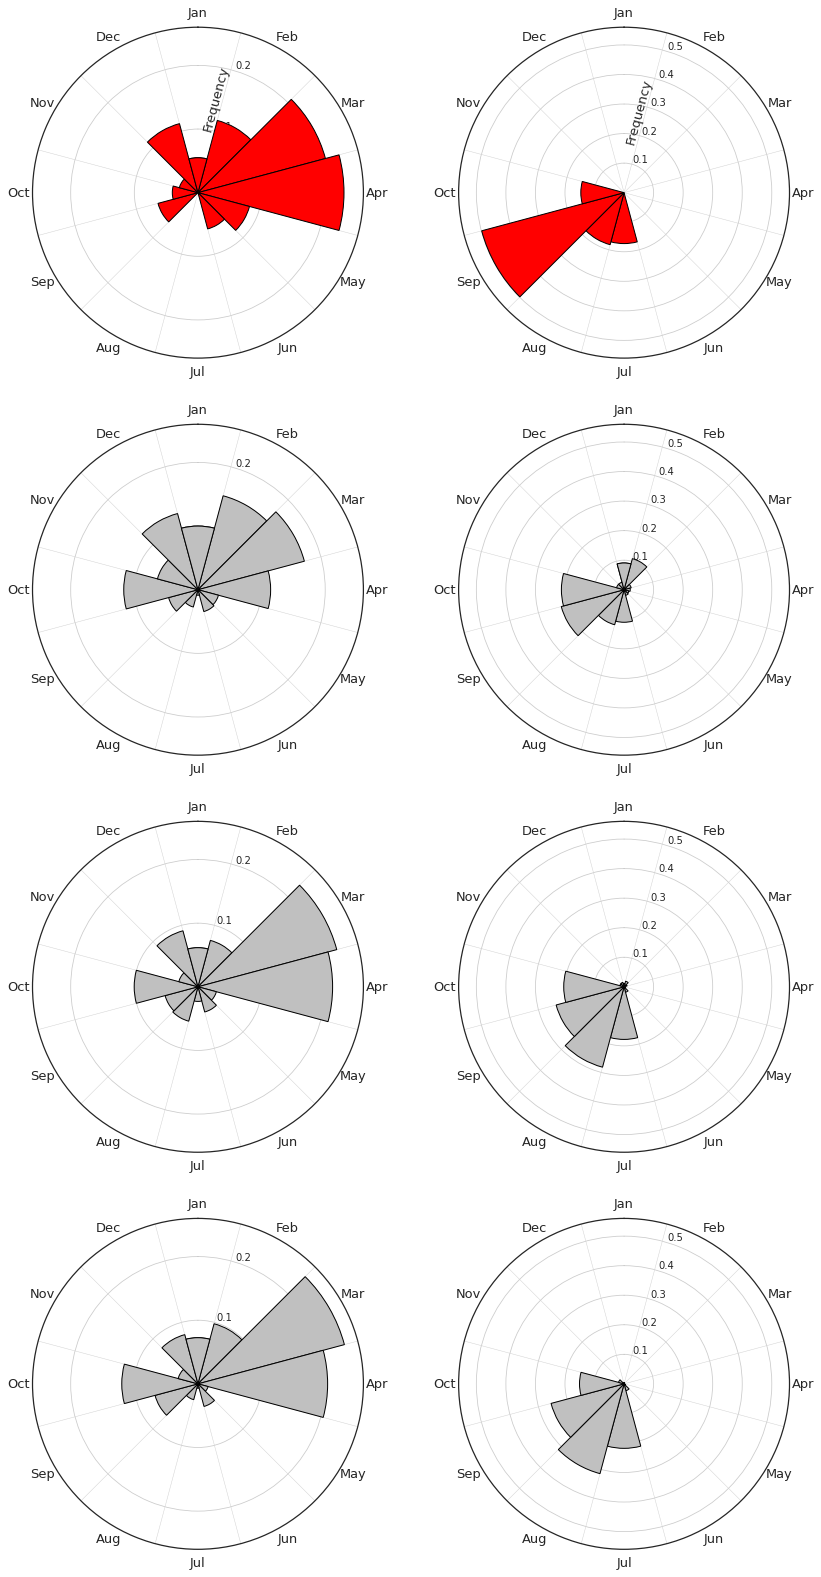

In [4]:
mag10_AnnualMax_months = np.zeros([1000, 530000])
mag10_low7_months = np.zeros([1000, 530000])
for i in range(1000):
    current_AnnualMax_months = np.load('Bootstrap_data/Months/HBV_AnnualMax_months/AnnualMax_months_{}.npy'.format(i))
    mag10_AnnualMax_months[i, :] = current_AnnualMax_months.flatten()
    current_low7_months = np.load('Bootstrap_data/Months/HBV_low7day_months/low7day_months_{}.npy'.format(i))
    mag10_low7_months[i, :] = current_low7_months.flatten()
mag10_AnnualMax_months = mag10_AnnualMax_months.flatten()
mag10_low7_months = mag10_low7_months.flatten()

PP_mag10_AnnualMax_months = np.zeros([1000, 530000])
PP_mag10_low7_months = np.zeros([1000, 530000])
for i in range(1000):
    current_AnnualMax_months = np.load('Bootstrap_data/Months/PP_HBV_AnnualMax_months/AnnualMax_months_{}.npy'.format(i))
    PP_mag10_AnnualMax_months[i, :] = current_AnnualMax_months.flatten()
    current_low7_months = np.load('Bootstrap_data/Months/PP_HBV_low7day_months/low7day_months_{}.npy'.format(i))
    PP_mag10_low7_months[i, :] = current_low7_months.flatten()
PP_mag10_AnnualMax_months = PP_mag10_AnnualMax_months.flatten()
PP_mag10_low7_months = PP_mag10_low7_months.flatten()

LSTM_mag10_AnnualMax_months = np.zeros([1000, 530000])
LSTM_mag10_low7_months = np.zeros([1000, 530000])
for i in range(1000):
    current_AnnualMax_months = np.load('Bootstrap_data/Months/LSTM_AnnualMax_months/AnnualMax_months_{}.npy'.format(i))
    LSTM_mag10_AnnualMax_months[i, :] = current_AnnualMax_months.flatten()
    current_low7_months = np.load('Bootstrap_data/Months/LSTM_low7day_months/low7day_months_{}.npy'.format(i))
    LSTM_mag10_low7_months[i, :] = current_low7_months.flatten()
LSTM_mag10_AnnualMax_months = LSTM_mag10_AnnualMax_months.flatten()
LSTM_mag10_low7_months = LSTM_mag10_low7_months.flatten()

mag10_obs_AnnualMax_months = np.load('Bootstrap_data/Months/obs_AnnualMax_months.npy')
mag10_obs_AnnualMax_months = mag10_obs_AnnualMax_months.flatten()
mag10_obs_low7_months = np.load('Bootstrap_data/Months/obs_low7day_months.npy')
mag10_obs_low7_months = mag10_obs_low7_months.flatten()

fig, axes = plt.subplots(4, 2, figsize=(14, 28), subplot_kw = {'projection':'polar'})

angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
angles = angles.tolist()
angles += angles[:1]
width = 2*np.pi/12
shifted_angles = np.array(angles[:-1]) + width/2
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

################################################## ANNUAL MAX #######################################################
##################### OBSERVED #####################
obs_months_freq = [np.sum(mag10_obs_AnnualMax_months==month)/len(mag10_obs_AnnualMax_months) for month in np.arange(1, 13)]
obs_months_freq += obs_months_freq[:1]
axes[0,0].grid(False, which='major', axis='x')
axes[0,0].set_xticks(angles[:-1])
axes[0,0].set_theta_zero_location('N')
axes[0,0].set_theta_direction(-1)
axes[0,0].set_xticklabels(month_labels, fontsize=13)
axes[0,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[0,0].axvline(i, color='lightgray', linewidth=0.5)
axes[0,0].bar(angles, obs_months_freq, align='center', color='r', edgecolor='k', width=width, zorder=10)
axes[0,0].text(0.05, 0.10, 'Frequency', size=13, rotation=90-(90/6))
axes[0,0].set_yticks([0.1, 0.2])
axes[0,0].set_rlabel_position(17)
axes[0,0].set_ylim((0, 0.26))

##################### SWM #####################
SWM_months_freq = [np.sum(mag10_AnnualMax_months==month)/len(mag10_AnnualMax_months) for month in np.arange(1, 13)]
SWM_months_freq += SWM_months_freq[:1]
axes[1,0].grid(False, which='major', axis='x')
axes[1,0].set_xticks(angles[:-1])
axes[1,0].set_theta_zero_location('N')
axes[1,0].set_theta_direction(-1)
axes[1,0].set_xticklabels(month_labels, fontsize=13)
axes[1,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[1,0].axvline(i, color='lightgray', linewidth=0.5)
axes[1,0].bar(angles, SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[1,0].set_yticks([0.1, 0.2])
axes[1,0].set_rlabel_position(17)
axes[1,0].set_ylim(axes[0,0].get_ylim())

##################### PP SWM #####################
PP_SWM_months_freq = [np.sum(PP_mag10_AnnualMax_months==month)/len(PP_mag10_AnnualMax_months) for month in np.arange(1, 13)]
PP_SWM_months_freq += PP_SWM_months_freq[:1]
axes[2,0].grid(False, which='major', axis='x')
axes[2,0].set_xticks(angles[:-1])
axes[2,0].set_theta_zero_location('N')
axes[2,0].set_theta_direction(-1)
axes[2,0].set_xticklabels(month_labels, fontsize=13)
axes[2,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[2,0].axvline(i, color='lightgray', linewidth=0.5)
axes[2,0].bar(angles, PP_SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[2,0].set_yticks([0.1, 0.2])
axes[2,0].set_rlabel_position(17)
axes[2,0].set_ylim(axes[0,0].get_ylim())

##################### LSTM #####################
LSTM_months_freq = [np.sum(LSTM_mag10_AnnualMax_months==month)/len(LSTM_mag10_AnnualMax_months) for month in np.arange(1, 13)]
LSTM_months_freq += LSTM_months_freq[:1]
axes[3,0].grid(False, which='major', axis='x')
axes[3,0].set_xticks(angles[:-1])
axes[3,0].set_theta_zero_location('N')
axes[3,0].set_theta_direction(-1)
axes[3,0].set_xticklabels(month_labels, fontsize=13)
axes[3,0].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[3,0].axvline(i, color='lightgray', linewidth=0.5)
axes[3,0].bar(angles, LSTM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[3,0].set_yticks([0.1, 0.2])
axes[3,0].set_rlabel_position(17)
axes[3,0].set_ylim(axes[0,0].get_ylim())

################################################## 7 DAY LOW #######################################################
##################### OBSERVED #####################
obs_months_freq = [np.sum(mag10_obs_low7_months==month)/len(mag10_obs_low7_months) for month in np.arange(1, 13)]
obs_months_freq += obs_months_freq[:1]
axes[0,1].grid(False, which='major', axis='x')
axes[0,1].set_xticks(angles[:-1])
axes[0,1].set_theta_zero_location('N')
axes[0,1].set_theta_direction(-1)
axes[0,1].set_xticklabels(month_labels, fontsize=13)
axes[0,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[0,1].axvline(i, color='lightgray', linewidth=0.5)
axes[0,1].bar(angles, obs_months_freq, align='center', color='r', edgecolor='k', width=width, zorder=10)
axes[0,1].text(0, 0.17, 'Frequency', size=13, rotation=90-(90/6))
axes[0,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[0,1].set_rlabel_position(17)
axes[0,1].set_ylim((0, 0.56))

##################### SWM #####################
SWM_months_freq = [np.sum(mag10_low7_months==month)/len(mag10_low7_months) for month in np.arange(1, 13)]
SWM_months_freq += SWM_months_freq[:1]
axes[1,1].grid(False, which='major', axis='x')
axes[1,1].set_xticks(angles[:-1])
axes[1,1].set_theta_zero_location('N')
axes[1,1].set_theta_direction(-1)
axes[1,1].set_xticklabels(month_labels, fontsize=13)
axes[1,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[1,1].axvline(i, color='lightgray', linewidth=0.5)
axes[1,1].bar(angles, SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[1,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[1,1].set_rlabel_position(17)
axes[1,1].set_ylim(axes[0,1].get_ylim())

##################### PP SWM #####################
PP_SWM_months_freq = [np.sum(PP_mag10_low7_months==month)/len(PP_mag10_low7_months) for month in np.arange(1, 13)]
PP_SWM_months_freq += PP_SWM_months_freq[:1]
axes[2,1].grid(False, which='major', axis='x')
axes[2,1].set_xticks(angles[:-1])
axes[2,1].set_theta_zero_location('N')
axes[2,1].set_theta_direction(-1)
axes[2,1].set_xticklabels(month_labels, fontsize=13)
axes[2,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[2,1].axvline(i, color='lightgray', linewidth=0.5)
axes[2,1].bar(angles, PP_SWM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[2,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[2,1].set_rlabel_position(17)
axes[2,1].set_ylim(axes[0,1].get_ylim())

##################### LSTM SWM #####################
LSTM_months_freq = [np.sum(LSTM_mag10_low7_months==month)/len(LSTM_mag10_low7_months) for month in np.arange(1, 13)]
LSTM_months_freq += LSTM_months_freq[:1]
axes[3,1].grid(False, which='major', axis='x')
axes[3,1].set_xticks(angles[:-1])
axes[3,1].set_theta_zero_location('N')
axes[3,1].set_theta_direction(-1)
axes[3,1].set_xticklabels(month_labels, fontsize=13)
axes[3,1].tick_params(axis='x', which='major', pad=7)
for i in shifted_angles:
    axes[3,1].axvline(i, color='lightgray', linewidth=0.5)
axes[3,1].bar(angles, LSTM_months_freq, align='center', color='silver', edgecolor='k', width=width, zorder=10)
axes[3,1].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
axes[3,1].set_rlabel_position(17)
axes[3,1].set_ylim(axes[0,1].get_ylim())

plt.show()

# <center> <font color = 'rebeccapurple'>Figure 9</font> </center>

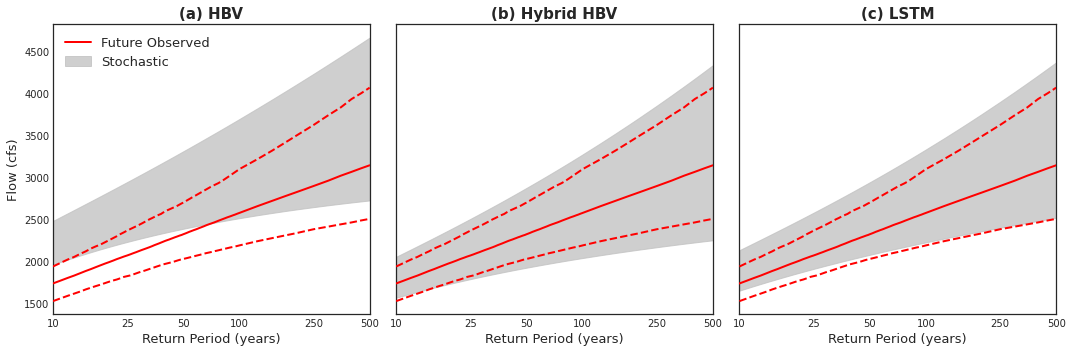

In [6]:
alf=0.025

hist_floods = pd.read_csv('Floods/HBV_Tyr_floods.csv')
flood_Ts = hist_floods.iloc[:, 0].values

mag10_floods = np.zeros([101, 10000*1000])
for i in range(1000):
    current_floods = np.load('Bootstrap_data/Floods/HBV_Tyr_floods/Tyr_floods_{}.npy'.format(i))
    for j in range(101):
        mag10_floods[j, i*10000:i*10000+10000] = current_floods[j]

PP_mag10_floods = np.zeros([101, 10000*1000])
for i in range(1000):
    current_floods = np.load('Bootstrap_data/Floods/PP_HBV_Tyr_floods/Tyr_floods_{}.npy'.format(i))
    for j in range(101):
        PP_mag10_floods[j, i*10000:i*10000+10000] = current_floods[j]
        
LSTM_mag10_floods = np.zeros([101, 10000*1000])
for i in range(1000):
    current_floods = np.load('Bootstrap_data/Floods/LSTM_Tyr_floods/Tyr_floods_{}.npy'.format(i))
    for j in range(101):
        LSTM_mag10_floods[j, i*10000:i*10000+10000] = current_floods[j]

mag10_obs_floods = pd.read_csv('Bootstrap_data/Floods/obs_Tyr_floods.csv')

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(flood_Ts, mag10_obs_floods.quantile(alf, axis=1), color='r', ls='--', zorder=10, lw=2)
ax1.plot(flood_Ts, mag10_obs_floods.quantile(1-alf, axis=1), color='r', ls='--', zorder=10, lw=2)
ax1.plot(flood_Ts, mag10_obs_floods.quantile(0.5, axis=1), color='r', label='Future Observed', zorder=10, lw=2)
ax1.fill_between(flood_Ts, np.quantile(mag10_floods, alf, axis=1), np.quantile(mag10_floods, 1-alf, axis=1), 
                 color='silver', label='Stochastic', alpha=0.75)
ax1.legend(fontsize=13)
ax1.set_ylabel('Flow (cfs)', size=13)
ax1.set_xscale('log')
ax1.set_xticks([10, 25, 50, 100, 250, 500], ['10', '25', '50', '100', '250', '500'])
ax1.set_xlim(10,500)
ax1.set_xlabel('Return Period (years)', size=13)
ax1.set_title('(a) HBV', weight='bold', size=15)

ax2 = fig.add_subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax2.plot(flood_Ts, mag10_obs_floods.quantile(alf, axis=1), color='r', ls='--', zorder=10, lw=2)
ax2.plot(flood_Ts, mag10_obs_floods.quantile(1-alf, axis=1), color='r', ls='--', zorder=10, lw=2)
ax2.plot(flood_Ts, mag10_obs_floods.quantile(0.5, axis=1), color='r', label='Observed', zorder=10, lw=2)
ax2.fill_between(flood_Ts, np.quantile(PP_mag10_floods, alf, axis=1), np.quantile(PP_mag10_floods, 1-alf, axis=1), 
                 color='silver', label='Stochastic', alpha=0.75)
ax2.yaxis.set_visible(False)
ax2.set_xlabel('Return Period (years)', size=13)
ax2.set_title('(b) Hybrid HBV', weight='bold', size=15)

ax3 = fig.add_subplot(1, 3, 3, sharex=ax1, sharey=ax1)
ax3.plot(flood_Ts, mag10_obs_floods.quantile(alf, axis=1), color='r', ls='--', zorder=10, lw=2)
ax3.plot(flood_Ts, mag10_obs_floods.quantile(1-alf, axis=1), color='r', ls='--', zorder=10, lw=2)
ax3.plot(flood_Ts, mag10_obs_floods.quantile(0.5, axis=1), color='r', label='Observed', zorder=10, lw=2)
ax3.fill_between(flood_Ts, np.quantile(LSTM_mag10_floods, alf, axis=1), np.quantile(LSTM_mag10_floods, 1-alf, axis=1), 
                 color='silver', label='Stochastic', alpha=0.75)
ax3.yaxis.set_visible(False)
ax3.set_xlabel('Return Period (years)', size=13)
ax3.set_title('(c) LSTM', weight='bold', size=15)

plt.tight_layout()
plt.show()

# <center> <font color = 'rebeccapurple'>Figure 10</font> </center>

In [21]:
def calc_Spring_Lmoments(model):
    data = pd.read_csv('Deterministic_models/Quaboag_'+model+'.csv')    
    data['date'] = pd.to_datetime(data['date'])
    data = data[(data['date'] <= '1995-09-30') | (data['date'] >= '2007-01-01')].reset_index(drop=True)
            
    Lmoments = np.ones((len(data['date'].dt.year.unique()[1:]), 4))*-99
    
    for j in range(len(data['date'].dt.year.unique()[1:])):
        year = data['date'].dt.year.unique()[1:][j]
        errors = data[(data['date'].dt.year==year) & (data['date'].dt.month.isin([3,4]))]['lambda'].values
        
        X = errors.copy()
        n = len(X)
        X = np.sort(X)
        
        b0 = np.mean(X)
        run_sum = 0
        for i in range(1,n):
            run_sum = run_sum + (i+1-1)*X[i]
        b1 = run_sum/(n*(n-1))
        run_sum = 0
        for i in range(2,n):
            run_sum = run_sum + (i+1-1)*(i+1-2)*X[i]
        b2 = run_sum/(n*(n-1)*(n-2))
        run_sum = 0
        for i in range(3,n):
            run_sum = run_sum + (i+1-1)*(i+1-2)*(i+1-3)*X[i]
        b3 = run_sum/(n*(n-1)*(n-2)*(n-3))
        run_sum = 0
        for i in range(4,n):
            run_sum = run_sum + (i+1-1)*(i+1-2)*(i+1-3)*(i+1-4)*X[i]
        b4 = run_sum/(n*(n-1)*(n-2)*(n-3)*(n-4))
        l1 = b0
        l2 = 2*b1-b0
        l3 = 6*b2-6*b1+b0
        l4 = 20*b3-30*b2+12*b1-b0
        LSK = l3/l2
        LKU = l4/l2
        
        Lmoments[j,0] = l1
        Lmoments[j,1] = l2
        Lmoments[j,2] = LSK
        Lmoments[j,3] = LKU
        
    return Lmoments

In [22]:
HBV_Lmoments_lambda = calc_Spring_Lmoments('HBV')
PP_HBV_Lmoments_lambda = calc_Spring_Lmoments('PP_HBV')
LSTM_Lmoments_lambda = calc_Spring_Lmoments('LSTM')

In [24]:
def linear_regression(x, y):
    # get rid of NaNs
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    # In order to have an intercept, we need to add a column of 1's to x
    x2 = sm.add_constant(x)

    # Fit the simple linear regression
    sm_model = sm.OLS(y, x2)
    results = sm_model.fit()

    return results

In [40]:
monthly_snowmelt_df = snowmelt_df = pd.read_csv('Climate/snowmelt.csv')
monthly_snowmelt_df['Date'] = pd.to_datetime(monthly_snowmelt_df['Date'])
monthly_snowmelt_df = monthly_snowmelt_df[(monthly_snowmelt_df['Date'] >= '1951-10-01') & (monthly_snowmelt_df['Date'] <= '2015-09-30')].reset_index(drop=True)
monthly_snowmelt_df = monthly_snowmelt_df[(monthly_snowmelt_df['Date'] <= '1995-09-30') | (monthly_snowmelt_df['Date'] >= '2007-01-01')].reset_index(drop=True)

snowmelt = np.ones(len(monthly_snowmelt_df['Date'].dt.year.unique()[1:]))*-99
    
for i in range(len(monthly_snowmelt_df['Date'].dt.year.unique()[1:])):
    year = monthly_snowmelt_df['Date'].dt.year.unique()[1:][i]
    Mar_snowmelt = monthly_snowmelt_df[(monthly_snowmelt_df['Date'].dt.year==year) & (monthly_snowmelt_df['Date'].dt.month==3)]['1176000'].sum()
    Apr_snowmelt = monthly_snowmelt_df[(monthly_snowmelt_df['Date'].dt.year==year) & (monthly_snowmelt_df['Date'].dt.month==4)]['1176000'].sum()
    snowmelt[i] = Mar_snowmelt + Apr_snowmelt

In [41]:
def normalize_array(array):
    # normalize this by subtracting the mean and dividing by the std
    mean = np.nanmean(array)
    std = np.nanstd(array)
    normalized_array = (array - mean)/std
    
    return normalized_array

In [42]:
normalized_snowmelt = normalize_array(snowmelt)

In [43]:
def slr_fig(Lmoment, Lmoment_name, ax):
    normalized_Lmoment = normalize_array(Lmoment)
    
    ax.scatter(snowmelt, Lmoment, color='silver')
    # get linear regression line
    res = linear_regression(x=normalized_snowmelt, y=normalized_Lmoment)
    # find slope of line
    intercept, slope = res.params
    r2 = res.rsquared
    p_val = res.pvalues[1]
    # plot line
    if p_val <= 5:
        # get full linear regression line to plot
        full_x = snowmelt.copy()
        full_y = Lmoment.copy()
        full_mask = ~np.isnan(full_x) & ~np.isnan(full_y)
        full_x = full_x[full_mask]
        full_y = full_y[full_mask]
        full_x_with_constant = sm.add_constant(full_x)
        full_model = sm.OLS(full_y, full_x_with_constant)
        full_results = full_model.fit()
        full_intercept, full_slope = full_results.params
        full_regression_line = full_intercept + full_slope*full_x
        ax.plot(full_x, full_regression_line, ls='-', color='r')
    ax.plot([],[],' ', label=f'R$^2$ = {r2:.2f}\n\u03B2 = {slope:.2f}\np-value = {p_val:.1e}')
    ax.legend(loc='upper left', fontsize=13, labelcolor='r')
    ax.set_xlabel('Cumulative Springtime Snowmelt', size=13)
    ax.set_ylabel('L-scale of Springtime \nModel Residuals', size=13)

In [44]:
def boxplots(ax):
    df1 = pd.read_csv('Linear_regressions/HBV_LambdasMR_Snow_Pval.csv')
    df1 = df1.drop('Site Number', axis=1)

    df2 = pd.read_csv('Linear_regressions/HBV_LSTM_LambdasMR_Snow_Pval.csv')
    df2 = df2.drop('Site Number', axis=1)
    
    df3 = pd.read_csv('Linear_regressions/LSTM_LambdasMR_Snow_Pval.csv')
    df3 = df3.drop('Site Number', axis=1)
    
    cols = df1.columns

    # Combine data into a tidy format for easy plotting
    df1_melted = df1.melt(var_name='Variable', value_name='Value')
    df1_melted['Source'] = 'df1'

    df2_melted = df2.melt(var_name='Variable', value_name='Value')
    df2_melted['Source'] = 'df2'
    
    df3_melted = df3.melt(var_name='Variable', value_name='Value')
    df3_melted['Source'] = 'df3'

    # Create side-by-side boxplots
    positions = np.arange(len(cols))
    width = 0.25

    # Plot each dataframe separately for offset positions
    b1 = ax.boxplot(
        [df1[c].dropna() for c in cols],
        positions=positions - width,
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor='orange', alpha=0.6),
        medianprops=dict(color='black')
    )

    b2 = ax.boxplot(
        [df2[c].dropna() for c in cols],
        positions=positions,
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor='cyan', alpha=0.6),
        medianprops=dict(color='black')
    )
    
    b3 = ax.boxplot(
        [df3[c].dropna() for c in cols],
        positions=positions + width,
        widths=width,
        patch_artist=True,
        boxprops=dict(facecolor='purple', alpha=0.6),
        medianprops=dict(color='black')
    )

    # Formatting
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 1)
    ax.set_xticks(positions)
    ax.set_xticklabels(['Mean','L-Scale','L-Skew','L-Kurtosis'], rotation=45, ha='right', size=13)
    ax.legend([b1["boxes"][0], b2["boxes"][0], b3["boxes"][0]], ['HBV', 'Hybrid HBV', 'LSTM'], loc='best', fontsize=12)
    ax.set_ylabel('Snowmelt P-Values', size=13)
    ax.axhline(1e-1, ls='--', color='r')

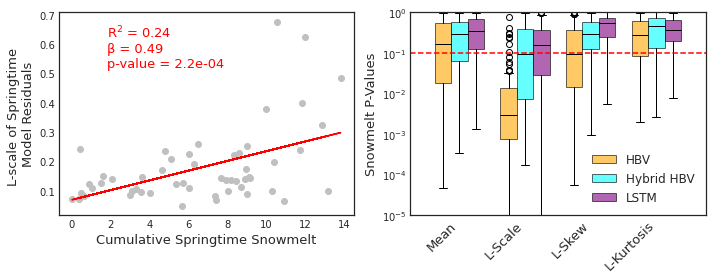

In [45]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

slr_fig(HBV_Lmoments_lambda[:, 1], 'L-scale', ax1)

boxplots(ax2)

plt.tight_layout()
plt.show()

# <center> <font color = 'rebeccapurple'>Getting data for all 74 sites</font> </center>

In [46]:
areas_df = pd.read_csv('Deterministic_models/All_sites/areas.csv')[['Site','DRAIN_SQKM']].drop_duplicates().reset_index(drop=True)

In [47]:
obs_data = pd.read_csv('Deterministic_models/All_sites/observed_flows.csv')
obs_data['Date'] = pd.to_datetime(obs_data['Date'])
obs_data = obs_data[(obs_data['Date'] >= '1951-10-01') & (obs_data['Date'] <= '2015-09-30')].reset_index(drop=True)
obs_data = obs_data[(obs_data['Date'] <= '1995-09-30') | (obs_data['Date'] >= '2006-10-01')].reset_index(drop=True)
obs_data.set_index('Date', inplace=True)
obs_data = obs_data.loc[:, obs_data.columns.isin(areas_df['Site'].astype(str))]
obs_data = obs_data.reindex(sorted(obs_data.columns), axis=1)
for site in obs_data.columns:
    obs_flows = obs_data[site].values
    for i in range(len(obs_flows)):
        if obs_flows[i] <= 0:
            obs_flows[i] = obs_flows[i-1]
    obs_data[site] = obs_flows

In [48]:
def get_sim_data(model):
    if model == 'PRMS':
        sim_data = pd.read_csv('Deterministic_models/All_sites/calibrated_PRMS_flows.csv')
        PP_data = pd.read_csv('Deterministic_models/All_sites/simulated_PRMS_LSTM_flow.csv')
    if model == 'Hymod':
        sim_data = pd.read_csv('Deterministic_models/All_sites/simulated_HYMOD_flow.csv')
        PP_data = pd.read_csv('Deterministic_models/All_sites/simulated_HYMOD_LSTM_flow.csv')
    if model == 'HBV':
        sim_data = pd.read_csv('Deterministic_models/All_sites/simulated_HBV_flow.csv')
        PP_data = pd.read_csv('Deterministic_models/All_sites/simulated_HBV_LSTM_flow.csv')
    if model == 'LSTM':
        sim_data = pd.read_csv('Deterministic_models/All_sites/LSTM_flows.csv')
        PP_data = pd.read_csv('Deterministic_models/All_sites/LSTM_flows.csv')
    
    sim_data['Date'] = pd.to_datetime(sim_data['Date'])
    sim_data = sim_data[(sim_data['Date'] >= '1951-10-01') & (sim_data['Date'] <= '2015-09-30')].reset_index(drop=True)
    sim_data = sim_data[(sim_data['Date'] <= '1995-09-30') | (sim_data['Date'] >= '2006-10-01')].reset_index(drop=True)
    sim_data.set_index('Date', inplace=True)
    sim_data = sim_data.loc[:, sim_data.columns.isin(obs_data.columns)]
    sim_data = sim_data.reindex(sorted(sim_data.columns), axis=1)
    if (model != 'PRMS') & (model != 'LSTM'):
        for site in sim_data.columns:
            area = areas_df[areas_df['Site'].astype(str) == site]['DRAIN_SQKM'].values[0]
            sim_data[site] = sim_data[site]*area*3280.84*3280.84/(60*60*24*304.8)
    for site in sim_data.columns:
        sim_flows = sim_data[site].values
        for i in range(len(sim_flows)):
            if sim_flows[i] <= 0:
                sim_flows[i] = sim_flows[i-1]
        sim_data[site] = sim_flows
    
    PP_data['Date'] = pd.to_datetime(PP_data['Date'])
    PP_data = PP_data[(PP_data['Date'] >= '1951-10-01') & (PP_data['Date'] <= '2015-09-30')].reset_index(drop=True)
    PP_data = PP_data[(PP_data['Date'] <= '1995-09-30') | (PP_data['Date'] >= '2006-10-01')].reset_index(drop=True)
    PP_data.set_index('Date', inplace=True)
    PP_data = PP_data.loc[:, PP_data.columns.isin(obs_data.columns)]
    PP_data = PP_data.reindex(sorted(PP_data.columns), axis=1)
    for site in PP_data.columns:
        area = areas_df[areas_df['Site'].astype(str) == site]['DRAIN_SQKM'].values[0]
        PP_data[site] = PP_data[site]*area*3280.84*3280.84/(60*60*24*304.8)
        PP_flows = PP_data[site].values
        for i in range(len(PP_flows)):
            if PP_flows[i] <= 0:
                PP_flows[i] = PP_flows[i-1]
        PP_data[site] = PP_flows
        
    return sim_data, PP_data